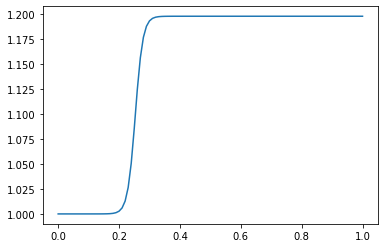

line worked


In [2]:
import dolfin as dolf
from math import pi, sqrt
import matplotlib.pyplot as plt
import numpy as np

from helmholtz_pkg.passive_flame import PassiveFlame
from helmholtz_pkg.flame_transfer_function import n_tau
from helmholtz_pkg.active_flame import ActiveFlame
from helmholtz_pkg.eigensolvers import fixed_point_iteration_pep
from helmholtz_pkg.eigenvectors import normalize_eigenvector, normalize_adjoint
from helmholtz_pkg.petsc4py_utils import vector_matrix_vector, mult_complex_scalar_real_matrix
import params

In [3]:
def mshr(el):

    mesh = dolf.UnitIntervalMesh(el)

    def l_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 0.)

    def r_boundary_func(x, on_boundary):
        x = x[0]
        return on_boundary and dolf.near(x, 1.)

    boundaries = dolf.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)

    l_boundary = dolf.AutoSubDomain(l_boundary_func)
    r_boundary = dolf.AutoSubDomain(r_boundary_func)

    l_boundary.mark(boundaries, 1)
    r_boundary.mark(boundaries, 2)

    # ________________________________________________________________________________

    def fl_subdomain_func(x):
        x = x[0]
        x_f = params.x_f[0][0]
        a_f = params.a_f
        return x_f - a_f - dolf.DOLFIN_EPS <= x <= x_f + a_f + dolf.DOLFIN_EPS

    subdomains = dolf.MeshFunction('size_t', mesh, mesh.topology().dim())

    subdomains.set_all(1)

    fl_subdomain = dolf.AutoSubDomain(fl_subdomain_func)
    fl_subdomain.mark(subdomains, 0)

    return mesh, boundaries, subdomains

In [4]:
degree = 1

mesh, boundaries, subdomains = mshr(400)

boundary_conditions = {1: {'Robin': params.Y_in},  # inlet
                        2: {'Robin': params.Y_out}}  # outlet

foo = PassiveFlame(mesh, boundaries, boundary_conditions,
                    c=params.c_,
                    degree=degree)
foo.assemble_A()
foo.assemble_B()
foo.assemble_C()

In [5]:
ftf = n_tau(params.n, params.tau)

D_base = ActiveFlame(mesh, subdomains,
                params.x_f, params.x_r, params.rho_in, 1., 1., ftf,
                degree=degree)

D_base.assemble_submatrices(problem_type='direct')
D_base.assemble_submatrices(problem_type='adjoint')

E_dir = fixed_point_iteration_pep(foo, D_base, pi, nev=2, i=0, problem_type='direct',tol=1e-15, maxiter=100)
E_adj = fixed_point_iteration_pep(foo, D_base, pi, nev=2, i=1, problem_type='adjoint',tol=1e-15, maxiter=100)

omega_base, p_base = normalize_eigenvector(mesh, E_dir, i=0, degree=degree, which='right')
omega_adj, p_adj = normalize_eigenvector(mesh, E_adj, i=1, degree=degree, which='left')

# BASE STATE SENSITIVITY ------------------------------------------------------------------------------------------

p_dir_vec = p_base.vector().vec()
p_adj_vec = p_adj.vector().vec()




iter =  1,  omega = +3.427581991086694  +0.014369810162020j,  |domega| = 1.29e-02
iter =  2,  omega = +3.425410406417154  +0.001990366417685j,  |domega| = 1.26e-02
iter =  3,  omega = +3.425410708138722  +0.001991532305515j,  |domega| = 1.20e-06
iter =  4,  omega = +3.425410708119894  +0.001991532251623j,  |domega| = 5.71e-11
iter =  5,  omega = +3.425410708119906  +0.001991532251622j,  |domega| = 1.24e-14
iter =  6,  omega = +3.425410708119855  +0.001991532251627j,  |domega| = 5.09e-14
iter =  7,  omega = +3.425410708119931  +0.001991532251624j,  |domega| = 7.56e-14
iter =  8,  omega = +3.425410708119920  +0.001991532251622j,  |domega| = 1.13e-14
iter =  9,  omega = +3.425410708119923  +0.001991532251622j,  |domega| = 3.19e-15
iter = 10,  omega = +3.425410708119923  +0.001991532251622j,  |domega| = 4.52e-16
iter =  1,  omega = +3.427581991086758  -0.014369810162021j,  |domega| = 1.29e-02
iter =  2,  omega = +3.425410406417217  -0.001990366417687j,  |domega| = 1.26e-02
iter =  3,  omeg

In [6]:
# sensitivity for tau
D_11,D_12,D_21,D_22 = D_base.submatrices
z = ftf(omega_base)*1j*omega_base
D_mat = D_base.coeff*mult_complex_scalar_real_matrix(z, D_11, D_12, D_21, D_22)
dNdtau = D_mat 
dNdtau

### Sensitivity of parameter Tau

In [7]:
norm_adj = normalize_adjoint(omega_base, p_base, p_adj, foo, D_base)
dsdtau = vector_matrix_vector(norm_adj.vector().vec(), dNdtau , p_dir_vec )
dsdtau

(-0.09884628637946874-0.012769113743431766j)

## Taylor Test for parameter tau

In [8]:
def find_new_s(tau):
    ftf = n_tau(params.n, tau)

    D = ActiveFlame(mesh, subdomains,
                    params.x_f, params.x_r, params.rho_in, 1., 1., ftf,
                    degree=degree)

    D.assemble_submatrices(problem_type='direct')


    E = fixed_point_iteration_pep(foo, D, pi, nev=2, i=0, problem_type='direct',tol=1e-13, maxiter=150)

    omega_new, p_new = normalize_eigenvector(mesh, E, i=0, degree=degree, which='right')
    
    return omega_new

## BASED ON ARFM PAPER

In [9]:
points = 10 # number of points
dtau = 0.0001
ddtau = np.zeros(points, dtype=complex)
epsilons = np.zeros(points)


In [10]:
tau_base = params.tau

for nn in range(1,points):
    
    # Calculate Adjoint Sensitivity
    ds_AD = dsdtau * nn * dtau 
    
    #New tau
    tau = tau_base + nn*dtau  
    
    
    print("new tau; ",tau, "new epsilon; ",nn*dtau  )
    
    # Calculate new eigenvalue with new n
    new_omega = find_new_s(tau)
    # Calculate FD Sensitivity
    ds_FD = (new_omega - omega_base)
    
    print("\ntau_base = ", params.tau, " tau1 = ", tau)
    print("\n", ds_AD, " ?= ",ds_FD,"\n")
    print(new_omega, " ?= ", omega_base + dsdtau*nn*dtau)
    

    ddtau[nn] = ds_AD - ds_FD 
    print("Difference: ", ds_AD - ds_FD)
    epsilons[nn] = nn*dtau 
    print("----------------------------------------------------------------------")
    

new tau;  0.5082306144206187 new epsilon;  0.0001
iter =  1,  omega = +3.4275770404696  +0.0143691095422j,  |domega| = 1.29e-02
iter =  2,  omega = +3.4254005212868  +0.0019890872260j,  |domega| = 1.26e-02
iter =  3,  omega = +3.4254008236846  +0.0019902537405j,  |domega| = 1.21e-06
iter =  4,  omega = +3.4254008236658  +0.0019902536865j,  |domega| = 5.71e-11
iter =  5,  omega = +3.4254008236658  +0.0019902536865j,  |domega| = 4.01e-15
Normalization relation is | p p dx = 1 

tau_base =  0.5081306144206187  tau1 =  0.5082306144206187

 (-9.884628637946874e-06-1.2769113743431766e-06j)  ?=  (-9.884454148068045e-06-1.2785651008224291e-06j) 

(3.4254008236657745+0.0019902536865216715j)  ?=  (3.4254008234912847+0.0019902553402481506j)
Difference:  (-1.744898788294118e-10+1.6537264792524937e-09j)
----------------------------------------------------------------------
new tau;  0.5083306144206187 new epsilon;  0.0002
iter =  1,  omega = +3.4275720900449  +0.0143684072077j,  |domega| = 1.29e-02

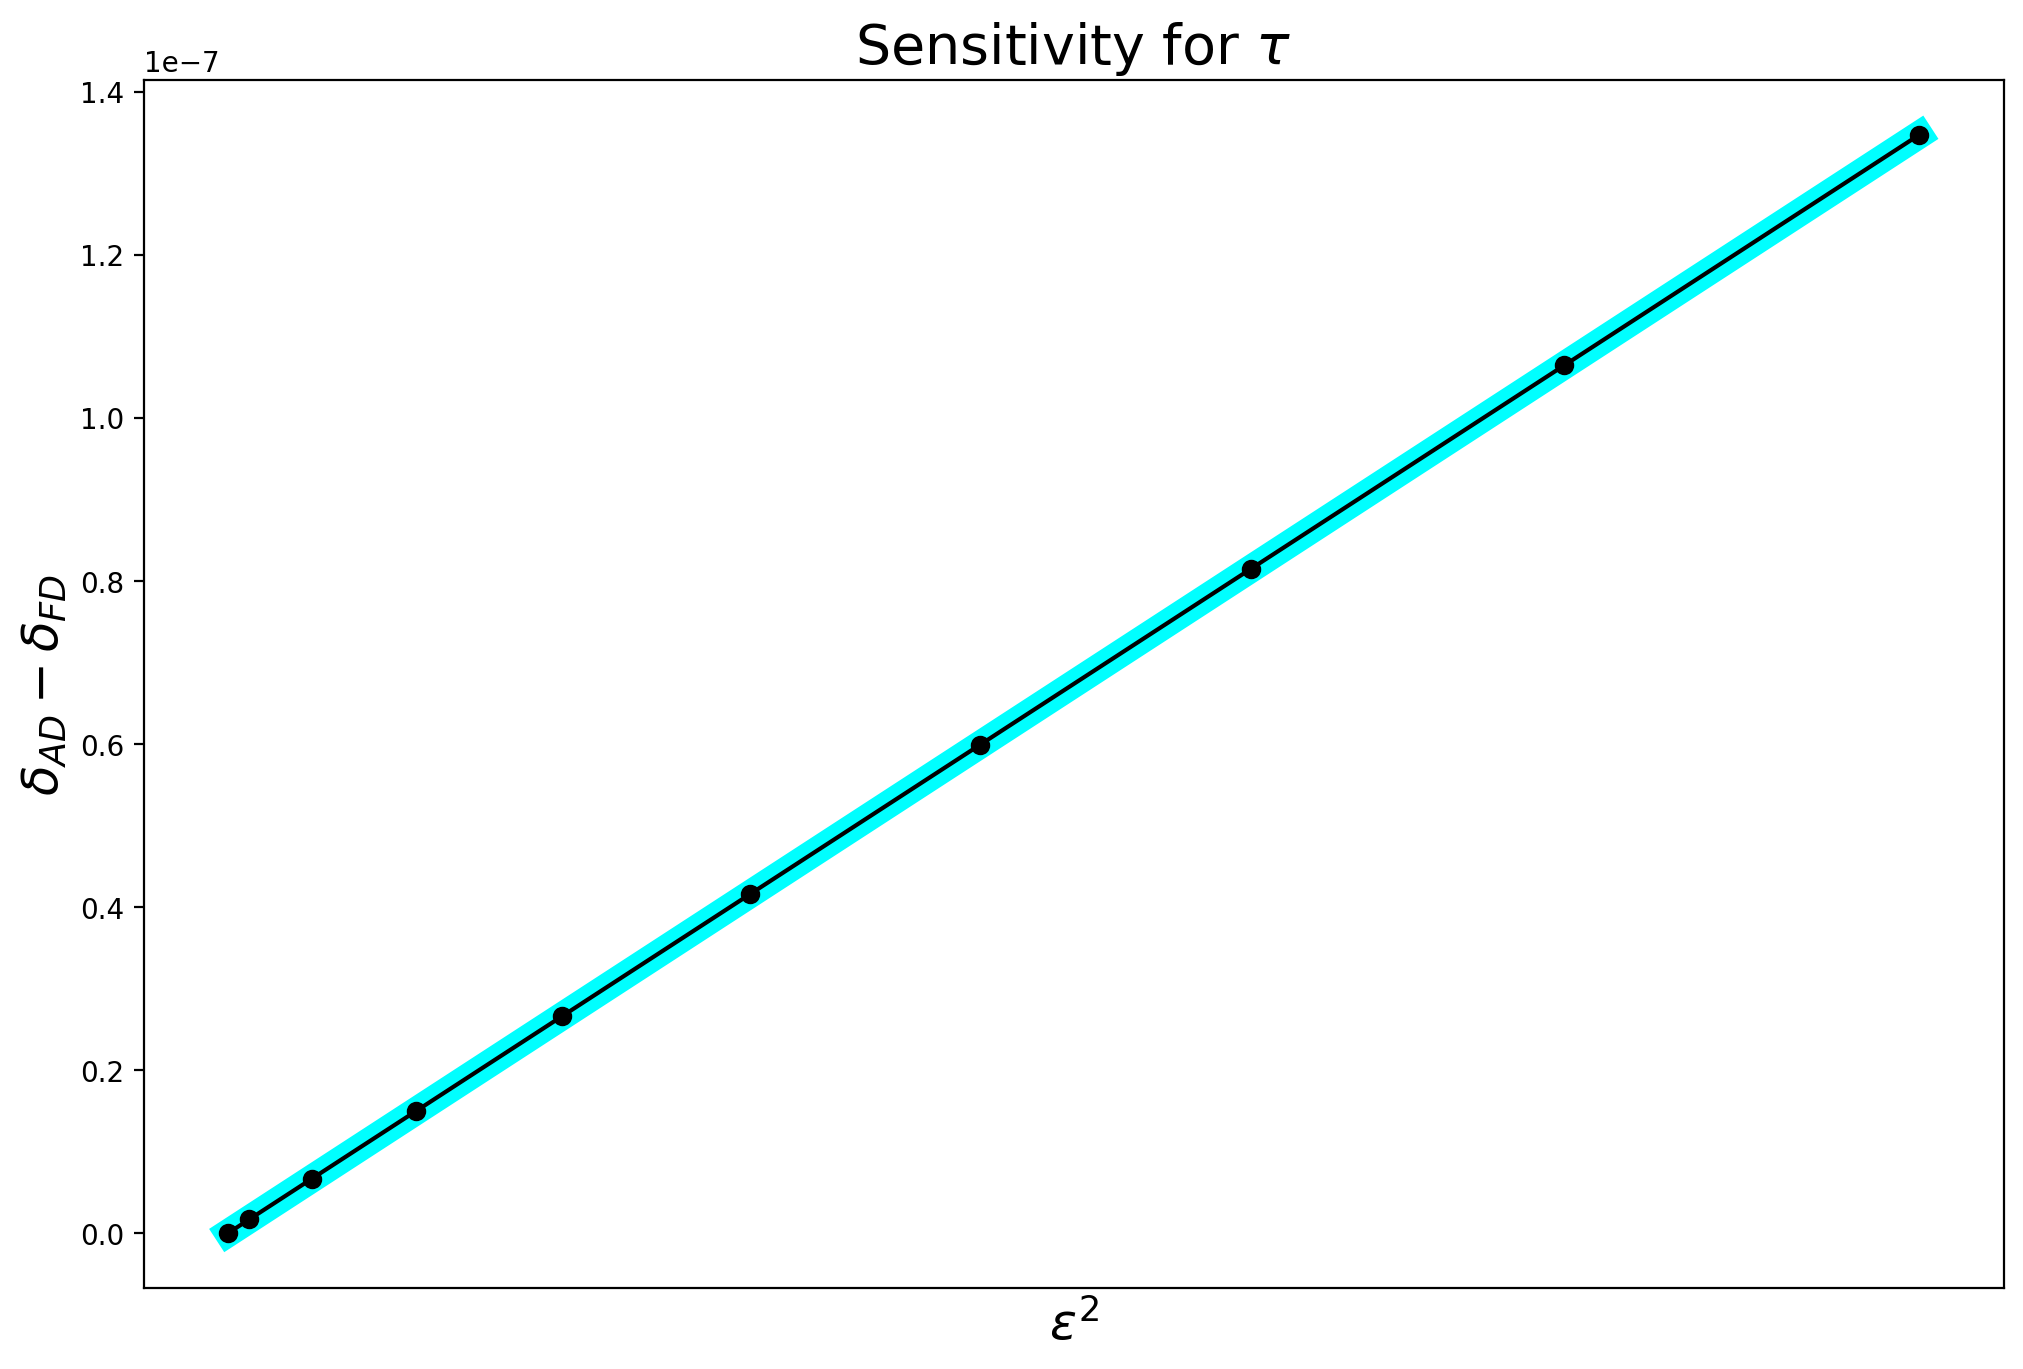

In [24]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

plt.plot([0,(points-1)**2],[0,max(abs(ddtau))], linewidth = 10.0, color='cyan') #Straight Line
plt.plot(np.arange(0,points)**2, abs(ddtau),'o-k') # Actual Line
plt.xticks([])
plt.title(r"Sensitivity for $\tau$", fontsize=20)
plt.xlabel(r"$\epsilon^2$", fontsize=18)
plt.ylabel(r"$\delta_{AD} - \delta_{FD}$", fontsize=18)
plt.show()
